In [ ]:
!pip install pillow
!pip install numpy
!pip install -U scikit-learn
!python -m pip install "tensorflow<2.11"

# Libraries

In [1]:
from PIL import Image
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import cv2
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import Library as mylib
from Library import CustomDataset

torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1650 SUPER'

In [2]:
# creazione dataset
path='../SubDataset'
name='TOY'
mylib.create_df_ipcv_diode(path,name='TOY')

In [33]:
# creazione dataset
path='F:/Datasets/DIODE_FULL'
mylib.create_df_ipcv_diode(path)

# Split dataset

In [ ]:
csv_path="../Csv/TOY.csv"
custom_dataset = CustomDataset(csv_path, test_size=0.3, random_state=42,perc_dataset=0.02)
train_loader = torch.utils.data.DataLoader(custom_dataset, batch_size=5, shuffle=True)

In [3]:
csv_path="../Csv/path_images.csv"
custom_dataset = CustomDataset(csv_path, test_size=0.3, random_state=42,perc_dataset=0.02)
train_loader = torch.utils.data.DataLoader(custom_dataset, batch_size=5, shuffle=True)

Element load :  43


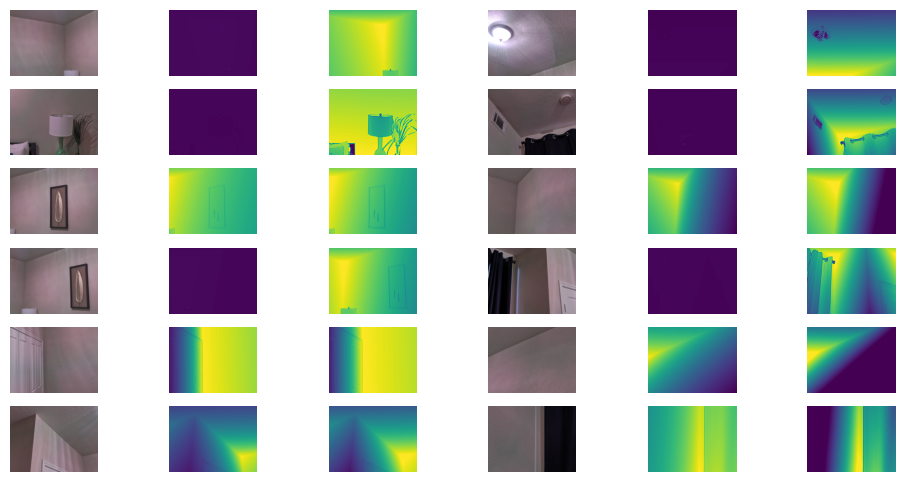

In [8]:
mylib.print_dataset(train_loader,6,6,0)

# Model

In [28]:
class ImageConverter(nn.Module):
    def __init__(self):
        super(ImageConverter, self).__init__()
        self.encoder = nn.Sequential( # Encoder
            # una convoluzione 2D con un kernel di dimensione 3x3, stride 1 e padding 1 che riceve in input immagini RGB con 3 canali e produce 32 feature map di output.
            nn.Conv2d(5, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential( # Decoder
            # una convoluzione trasposta 2D con un kernel di dimensione 3x3, stride 2, padding 1 e output padding 1 che riceve in input feature map di dimensioni ridotte prodotte dall'encoder e produce 64 feature map di output.
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, kernel_size=1, stride=1)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [10]:
model = ImageConverter()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5

In [29]:
model = ImageConverter()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5

for epoch in range(num_epochs):
    running_loss = 0.0
    for data in train_loader:
        
        images, img_rgbd, img_norm = data = data # Prendiamo le immagini dal dataloader
        print(type(images))
        optimizer.zero_grad() # Azzeriamo i gradienti del modello
        outputs = model(images) # Passiamo l'immagine attraverso il modello per ottenere l'output
        loss = criterion(outputs, images)# Calcoliamo la loss tra output e immagine originale
        loss.backward() # Calcoliamo i gradienti e aggiorniamo i pesi del modello
        optimizer.step()
        running_loss += loss.item() * images.size(0) # Aggiorniamo la running loss
    
    epoch_loss = running_loss / len(train_loader.dataset) # Calcoliamo la media della running loss

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_loss)) # Stampiamo la loss media per ogni epoca


<class 'torch.Tensor'>


RuntimeError: Given groups=1, weight of size [32, 5, 3, 3], expected input[5, 768, 1024, 3] to have 5 channels, but got 768 channels instead

# Functions